In [128]:
import numpy as np
import math
from matplotlib import pyplot as plt
import torch

/home/dhy/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:

def beamspace_channel(M, K, L, angle=0):
    """M 天线数   K 用户数   L 路径数"""

    m = np.arange(M)
    fai_m = 1 / M * (m - (M ) / 2);

    '''傅里叶变换矩阵'''
    U = []
    for i in range(M):
        U.append(1/math.sqrt(M)*np.exp(-1j*2*np.pi*fai_m[i]*m))

    U = np.array(U)
    U = U.conjugate()

    G = []
    for k in range(K):
        #Los_gain = (1+np.random.randn(1)*0.5)*np.exp(1j*np.random.rand(1)*2*np.pi) 
        #距离默认是100  pathloss增加了10^10 不然太小
        # Los_loss = 61.4 + 20*2 + np.random.randn(1)*math.pow(10,0.58)
        # Los_loss = math.pow(10, (100-Los_loss)/10)
        # Los_gain = Los_gain*Los_loss
        Los_gain = np.random.randn(1) + 1j*np.random.randn(1)
        #Los_gain = (1 + np.random.randn(1) * 0.2) * np.exp(1j * np.random.rand(1) * 2 * np.pi)
        theta =  2*np.pi * np.random.rand(1)+np.pi/2
        #固定角度
        #theta = np.pi * k / K+np.pi/2#+np.random.randn(1)*1/K*np.pi+angle
        fai = np.sin(theta)/2
        fai = (np.random.rand(1)-0.5)#*1/K +k/K
        g =  Los_gain*1/math.sqrt(M)*np.exp(-1j*2*np.pi*fai*m);
        for l in range(L-1):
            # nLos_gain = np.random.randn(1) + 1j * np.random.randn(1)
            # nLos_loss = 72 + 29.2 * 2 + np.random.randn(1) * math.pow(10, 0.87)
            # nLos_loss = math.pow(10, (100 - nLos_loss) / 10)
            # nLos_gain = nLos_gain * nLos_loss
            nLos_gain = np.sqrt(0.2)*(np.random.randn(1) + 1j*np.random.randn(1))
            theta = 2 * np.pi * np.random.rand(1)
            fai = np.sin(theta) / 2
            fai = np.random.rand(1)-0.5
            g = g + nLos_gain * 1 / math.sqrt(M) * np.exp(-1j * 2 * np.pi * fai * m);
        G.append(g)
    G = np.array(G)
    H = np.dot(U,G.T)


    """画出每个beam的能量"""
    beam_energy = np.sum(np.abs(H),1)
    # print(beam_energy)
    plt.plot(m,beam_energy)
    plt.show()

    return  H

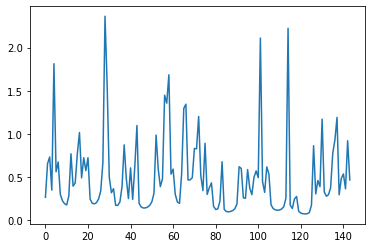

In [4]:
H_beam = beamspace_channel(M=144, K=4, L=16)

# Extension of S-V channel model
* ref: https://blog.csdn.net/qq_23947237/article/details/89925088
    * https://blog.csdn.net/qq_39227541/article/details/119358373
* Base station is at (0,0,height)
* coordinates of cluster center will be generated randomly
* N_ray Scatter will be generated randomly around cluster center
* each scatter will create an NLOS path with a random complex parameter beta
* there will be a LOS path directly from transmitter & receiver

<center class = "half">
<img src="./pics/defi.jpg" style="zoom:27%;"/>
<img src="./pics/defi1.jpg" style="zoom:33%;"/>
<img src="./pics/lcs_gcs.jpg" style="zoom:33%;"/>
</center>

In [11]:
'''
Author: dhy
Mail: git config user.email
Date: 2022-11-22 10:56:58
LastEditors: dhy
LastEditTime: 2022-11-24 06:56:01
FilePath: /PyMIMO/test.ipynb
Description: 

Copyright (c) 2022 by dhy 3057931787@qq.com, All Rights Reserved. 
'''
class Pos():
    def __init__(self, x , y, z) -> None:
        self.x = x
        self.y = y
        self.z = z
    def vector(self,):
        return np.array([self.x,self.y,self.z])
    def get_angle(self,):
        x,y,z = self.x, self.y, self.z
        if x == 0 and y == 0 and z == 0:
            raise ValueError("Cannot derive angle from O")
        d = np.sqrt(x**2 + y**2 + z**2)
        x = x/d
        y = y/d
        z = z/d
        L_elevation = np.arccos(z)
        L_azimuth = np.arctan(y/x)
        return L_azimuth, L_elevation

        
class UPA():
    def __init__(self, H_ant_num, V_ant_num, bearing = 0*np.pi, downtilt = 0*np.pi, slant = 0*np.pi) -> None:
        # The angle alpha is called the bearing angle, beta is called the downtilt angle and gamma is called the slant angle.
        self.H_ant_num = H_ant_num
        self.V_ant_num = V_ant_num
        self.bearing =  bearing
        self.downtilt = downtilt
        self.slant = slant

    def get_array_response(self, G_azimuth, G_elevation):
        # H_angle V_angle are from LCS
        # antenna lies in local zOy plane
        # change GCS angles to LCS
        L_azimuth, L_elevation = self.Angle_From_GCS_to_LCS(G_azimuth, G_elevation)
        vector_V = np.exp(1j * np.arange(start=0, stop=self.V_ant_num , step=1, dtype=np.complex128) * np.pi * np.cos(L_elevation))
        vector_H = np.exp(1j * np.arange(start=0, stop=self.H_ant_num , step=1, dtype=np.complex128) * np.pi *np.sin(L_azimuth) * np.sin(L_elevation))
        beams = np.kron(vector_V,vector_H)
        y = beams/np.sqrt(self.H_ant_num *self.V_ant_num )
        return y

    def Coordinate_From_GCS_to_LCS(self, G_pos : Pos):
        R_z = np.array([[np.cos(self.bearing), -np.sin(self.bearing), 0],[np.sin(self.bearing), np.cos(self.bearing), 0],[0, 0, 1]])
        R_y = np.array([[np.cos(self.downtilt), 0, np.sin(self.downtilt)],[0,1,0],[-np.sin(self.downtilt), 0, np.cos(self.downtilt)]])
        R_x = np.array([[1,0,0],[0,np.cos(self.slant),-np.sin(self.slant)],[0,np.sin(self.slant),np.cos(self.slant)]])
        R = R_z@R_y@R_x
        R_reverse = R.T
        Lvec = R_reverse @ G_pos.vector()
        Lpos = Pos(Lvec[0],Lvec[1],Lvec[2]) 
        return Lpos

    def Angle_From_GCS_to_LCS(self, azimuth, elevation):
        # unit vector coordinates of the path 
        x_G = np.sin(elevation) * np.cos(azimuth)
        y_G = np.sin(elevation) * np.sin(azimuth)
        z_G = np.cos(elevation)
        G_pos = Pos(x_G,y_G,z_G)
        Lpos = self.Coordinate_From_GCS_to_LCS(G_pos)
        L_azimuth, L_elevation = Lpos.get_angle()
        return L_azimuth, L_elevation
        # 


In [52]:

class Transmitter():
    def __init__(self, H_ant_num=4, V_ant_num=4, N_s=3, pos : Pos = Pos(0,0,10), bearing = 0*np.pi, downtilt = 0*np.pi, slant = 0*np.pi) -> None:
        self.pos = pos
        self.array = UPA(H_ant_num, V_ant_num, bearing = bearing, downtilt = downtilt, slant = slant)
        self.Nt_H = H_ant_num
        self.Nt_V = V_ant_num
        self.N_s = N_s
    def get_position(self,):
        return self.pos
    def set_position(self, pos : Pos):
        self.pos = pos

        
class Receiver():
    def __init__(self, H_ant_num=2, V_ant_num=2, N_s=3, pos : Pos = Pos(1,0,0), bearing = 1*np.pi, downtilt = 0*np.pi, slant = 0*np.pi) -> None:
        self.array = UPA(H_ant_num, V_ant_num, bearing = bearing, downtilt = downtilt, slant = slant)
        self.Nt_H = H_ant_num
        self.Nt_V = V_ant_num
        self.N_s = N_s
        self.pos = pos

    def get_position(self,):
        return self.pos
    def set_position(self, pos : Pos):
        self.pos = pos



In [120]:
def get_angle_from_A_to_B(a,b):
        x,y,z = b[:,0]-a[:,0], b[:,1]-a[:,1], b[:,2]-a[:,2]
        d = np.sqrt(x**2 + y**2 + z**2)
        x = x/d
        y = y/d
        z = z/d
        L_elevation = np.expand_dims(np.arccos(z), axis=-1)
        L_azimuth = np.expand_dims(np.arctan(y/x),  axis=-1)
        return np.concatenate([L_azimuth, L_elevation],axis=-1)
get_angle_from_A_to_B(np.array([[0,0,0],[1,1,1],[1,0,1]]),np.array([[1,1,1],[2,2,2],[44,1,0]])).shape

(3, 2)

In [182]:

class Cluster():
    def __init__(self, center : Pos = Pos(1,1,1), scatter_std : float = 0.5, N_ray = 10) -> None:
        self.N_ray = N_ray
        self.scatter_pos = np.array([center.vector() for i in range(N_ray)])
        self.scatter_std = np.random.normal(loc=0, scale=scatter_std, size=[N_ray,3])
        self.scatter_pos += self.scatter_std

class Channel():
    def __init__(self, tx : Transmitter, rx : Receiver, \
                 N_cluster : int, N_ray : int, realization : int) -> None:
        self.tx = tx
        self.rx = rx
        self.Ns = tx.N_s
        self.N_ray = N_ray
        self.N_cluster = N_cluster
        self.realization = realization
        #
        self.Nt = int(tx.Nt_H*tx.Nt_V)
        self.Nr = int(rx.Nt_H*rx.Nt_V)
        # initialize arrays
        self.AoA = np.zeros((2, N_cluster*N_ray))
        self.AoD = np.zeros((2, N_cluster*N_ray))
        self.H = np.zeros((self.Nr,self.Nt,realization),dtype=np.complex64)
        self.At = np.zeros((self.Nt,N_cluster*N_ray,realization),dtype=np.complex64)
        self.Ar = np.zeros((self.Nr,N_cluster*N_ray,realization),dtype=np.complex64)
        self.At_los = np.zeros((self.Nt,realization),dtype=np.complex64)
        self.Ar_los = np.zeros((self.Nr,realization),dtype=np.complex64)
        #
        self.gamma = np.sqrt((tx.Nt_H*tx.Nt_V*rx.Nt_H*rx.Nt_V)/(N_cluster*N_ray)) # normalization factor
        sigma = 1 # according to the normalization condition of the H
        self.count = 0
        #
        K = 10 # Rican Factor
        self.alpha = np.random.normal(0,np.sqrt(1/K*sigma/2),size=[N_cluster*N_ray,realization]) + 1j*np.random.normal(0,np.sqrt(1/K*sigma/2),size=[N_cluster*N_ray,realization])
        self.los_alpha = np.random.normal(0,np.sqrt(sigma/2),size=[realization]) + 1j*np.random.normal(0,np.sqrt(sigma/2),size=[realization])
        #
        self.Fopt =  np.zeros((self.Nt,tx.N_s,realization),dtype=np.complex64)
        self.Wopt =  np.zeros((self.Nr,tx.N_s,realization),dtype=np.complex64)
        # simulation params
        self.simulate()
        self.calulate_R()

    def simulate(self):    
        for reali in range(self.realization):
            # generate geographic scatter
            cluster_z = np.random.uniform(low=-5+self.tx.pos.z,high=5+self.tx.pos.z,size=[self.N_cluster])
            cluster_y = np.random.uniform(low=-self.rx.pos.y-5,high=self.rx.pos.y+5,size=[self.N_cluster])
            cluster_x = np.random.uniform(low=2,high=self.rx.pos.x,size=[self.N_cluster])
            cluster_center = [Pos(cluster_x[k],cluster_y[k],cluster_z[k]) for k in range(self.N_cluster)]
            clusters = [Cluster(cluster_center[p], N_ray=self.N_ray) for p in range(self.N_cluster)]
            self.scatters = np.concatenate([cluster.scatter_pos for cluster in clusters], axis=0)
            self.starts = np.repeat(self.tx.pos.vector().reshape(1,3),len(self.scatters),axis=0)
            self.ends = np.repeat(self.rx.pos.vector().reshape(1,3),len(self.scatters),axis=0)
            # generate NLOS AOA AOD
            self.AoD = get_angle_from_A_to_B(self.starts, self.scatters).transpose(1,0)
            self.AoA = get_angle_from_A_to_B(self.ends, self.scatters).transpose(1,0)
            # calculate LOS AOA AOD
            self.LOS_AoD = get_angle_from_A_to_B(self.tx.pos.vector().reshape(1,3), self.rx.pos.vector().reshape(1,3)).transpose(1,0)
            self.LOS_AoA = get_angle_from_A_to_B(self.rx.pos.vector().reshape(1,3), self.tx.pos.vector().reshape(1,3)).transpose(1,0)
            # add LOS
            self.At_los[:,reali] = self.tx.array.get_array_response(self.LOS_AoD[0],self.LOS_AoD[1]) # UPA array response
            self.Ar_los[:,reali] = self.rx.array.get_array_response(self.LOS_AoA[0],self.LOS_AoA[1])
            self.H[:,:,reali] = self.H[:,:,reali] + self.los_alpha[reali] * np.expand_dims(self.Ar_los[:,reali],axis=-1) @ np.expand_dims(np.conjugate(self.At_los[:,reali].T),axis=0)
            # add NLOS
            for j in range(0,self.N_cluster*self.N_ray):
                self.At[:,j,reali] = self.tx.array.get_array_response(self.AoD[0,j],self.AoD[1,j]) # UPA array response
                self.Ar[:,j,reali] = self.rx.array.get_array_response(self.AoA[0,j],self.AoA[1,j])
                self.H[:,:,reali] = self.H[:,:,reali] + self.alpha[j,reali] * np.expand_dims(self.Ar[:,j,reali],axis=-1) @ np.expand_dims(np.conjugate(self.At[:,j,reali].T),axis=0)

            self.H[:,:,reali] = self.gamma * self.H[:,:,reali]
            
            if(np.linalg.matrix_rank(self.H[:,:,reali])>=self.Ns):
                self.count = self.count + 1
                [U,S,V] = np.linalg.svd(self.H[:,:,reali],full_matrices=True)
                self.Fopt[:,:,reali] = V[0:self.Nt,0:self.Ns]
                self.Wopt[:,:,reali] = U[0:self.Nr,0:self.Ns]
        print(self.count,"RANK>Ns")

    def calulate_R(self,):
        SNR_dB = np.arange(start=-20,stop=20,step=5)
        SNR = 10**(SNR_dB/10)
        self.Ro = np.zeros((SNR_dB.shape[0],self.realization))
        for reali in range(self.realization):
            for s in range(SNR_dB.shape[0]):
                self.Ro[s,reali] = np.log2(np.linalg.det(np.eye(self.Ns) + SNR[s]/self.Ns * np.linalg.pinv(self.Wopt[:,:,reali]) @ self.H[:,:,reali] @ self.Fopt[:,:,reali] @ np.conjugate(self.Fopt[:,:,reali].T) @ np.conjugate(self.H[:,:,reali].T) @ self.Wopt[:,:,reali]))

In [179]:
np.linalg.p

(8,)

In [169]:
tx = Transmitter(pos=Pos(0,0,10))
rx = Receiver(pos=Pos(5,5,2))

In [183]:
ch = Channel(tx,rx,N_cluster=5,N_ray=10,realization=10)

10 RANK>Ns


/tmp/ipykernel_2116512/4001568596.py:85: ComplexWarning:

Casting complex values to real discards the imaginary part



In [188]:
np.sum(ch.Ro, axis=-1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='lines'))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines+markers',
                    name='lines+markers'))
fig.show()

array([ 0.19038213,  0.5956846 ,  1.82437565,  5.27901432, 13.56797076,
       29.33876958, 53.20776678, 83.98297669])

In [176]:
import plotly.express as px
import plotly.graph_objects as go
x, y, z = ch.scatters[:,0],ch.scatters[:,1],ch.scatters[:,2]
c = np.kron(np.arange(ch.N_cluster),10*np.ones(ch.N_ray))
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   marker=dict(
                                    size=2,
                                    color=c,                # set color to an array/list of desired values
                                    colorscale='hsv',   # choose a colorscale
                                    opacity=0.8)))
fig.add_trace(go.Scatter3d(x=[ch.tx.pos.x], y=[ch.tx.pos.y], z=[ch.tx.pos.z],
                                   mode='markers',
                                   marker=dict(
                                    size=10,
                                    line_width=1,
                                    color='blue',
                                    symbol='diamond')))
fig.add_trace(go.Scatter3d(x=[ch.rx.pos.x], y=[ch.rx.pos.y], z=[ch.rx.pos.z],
                                   mode='markers',
                                   marker=dict(
                                    size=10,
                                    line_width=1,
                                    color='pink',
                                    symbol='diamond')))

fig.show()